In [ ]:
!nvidia-smi

Sat Sep 26 09:01:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip '/content/gdrive/My Drive/Colab Notebooks/tbh+clahe.zip' -d '/content'

Archive:  /content/gdrive/My Drive/Colab Notebooks/tbh+clahe.zip
   creating: /content/tbh+clahe/
   creating: /content/tbh+clahe/test/
   creating: /content/tbh+clahe/test/cxrs/
  inflating: /content/tbh+clahe/test/cxrs/MCUCXR_0048_0.png  
  inflating: /content/tbh+clahe/test/cxrs/MCUCXR_0005_0.png  
  inflating: /content/tbh+clahe/test/cxrs/MCUCXR_0013_0.png  
  inflating: /content/tbh+clahe/test/cxrs/MCUCXR_0061_0.png  
  inflating: /content/tbh+clahe/test/cxrs/MCUCXR_0338_1.png  
  inflating: /content/tbh+clahe/test/cxrs/MCUCXR_0070_0.png  
  inflating: /content/tbh+clahe/test/cxrs/MCUCXR_0083_0.png  
  inflating: /content/tbh+clahe/test/cxrs/MCUCXR_0047_0.png  
  inflating: /content/tbh+clahe/test/cxrs/MCUCXR_0080_0.png  
  inflating: /content/tbh+clahe/test/cxrs/MCUCXR_0266_1.png  
  inflating: /content/tbh+clahe/test/cxrs/MCUCXR_0024_0.png  
  inflating: /content/tbh+clahe/test/cxrs/MCUCXR_0101_0.png  
  inflating: /content/tbh+clahe/test/cxrs/MCUCXR_0071_0.png  
  inflating: /c

In [ ]:
!pip install efficientnet

     |████████████████████████████████| 51kB 4.2MB/s 


In [ ]:
%load_ext tensorboard

In [ ]:
from glob import glob
import os
import numpy as np
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, Add
from efficientnet.tfkeras import EfficientNetB4
from tensorflow.keras import Model
from tensorflow.keras.layers import MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import *
import tensorflow as tf
from tensorflow.keras.optimizers import Nadam
import datetime
import matplotlib.pyplot as plt

# Set Global Variables and Directories
BATCH_SIZE = 5
EPOCHS = 250
segmentation_train_path = '/content/tbh+clahe/train/'
segmentation_validation_path = '/content/tbh+clahe/validation/'
segmentation_test_path = '/content/tbh+clahe/test/'
segmentation_train_image_path = '/content/tbh+clahe/train/cxrs/'
segmentation_validation_image_path = '/content/tbh+clahe/validation/cxrs/'
segmentation_test_image_path = '/content/tbh+clahe/test/cxrs/'
train_files = glob(os.path.join(segmentation_train_image_path, "*.png"))
val_files = glob(os.path.join(segmentation_validation_image_path, "*.png"))
test_files = glob(os.path.join(segmentation_test_image_path, "*.png"))


# Define Keras Image Data Generators for training and validation sets
def train_generator(batch_size, train_path, image_folder, mask_folder, aug_dict,
                    image_color_mode="rgb",
                    mask_color_mode="grayscale",
                    target_size=(512, 512),
                    seed=420):
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    seed = np.random.randint(seed)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes=[image_folder],
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        seed=seed,
        shuffle=True)

    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes=[mask_folder],
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        seed=seed,
        shuffle=True)

    for (img, mask) in zip(image_generator, mask_generator):
        img, mask = normalise(img, mask)
        yield img, mask


def val_generator(batch_size, train_path, image_folder, mask_folder,
                  image_color_mode="rgb",
                  mask_color_mode="grayscale",
                  target_size=(512, 512)):
    image_datagen = ImageDataGenerator()
    mask_datagen = ImageDataGenerator()
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes=[image_folder],
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        shuffle=False)

    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes=[mask_folder],
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        shuffle=False)

    for (img, mask) in zip(image_generator, mask_generator):
        img, mask = normalise(img, mask)
        yield img, mask


# Helper Function for normalizing data
def normalise(img, mask):
    img = img / 255.0
    mask = mask / 255.0
    mask[mask > 0.5] = 1.0
    mask[mask <= 0.5] = 0.0
    return img, mask


# Define Loss Functions
smooth = 1e-6


def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)


def generalised_dice_loss_2d(Y_gt, Y_pred):
    w = tf.reduce_sum(Y_gt)
    w = 1 / (w ** 2 + smooth)

    numerator = Y_gt * Y_pred
    numerator = w * tf.reduce_sum(numerator)
    numerator = tf.reduce_sum(numerator)

    denominator = Y_pred + Y_gt
    denominator = w * tf.reduce_sum(denominator)
    denominator = tf.reduce_sum(denominator)

    gen_dice_coef = 2 * numerator / (denominator + smooth)
    loss = tf.reduce_mean(1 - gen_dice_coef)
    return loss


def pgdl(y_true, y_pred):
    k = 2.5
    gd = generalised_dice_loss_2d(y_true, y_pred)
    loss = gd / (1 + k * (1 - gd))
    return loss


loss_weight = 0.9


def loss(y_true, y_pred):
    return loss_weight * pgdl(y_true, y_pred) + (1 - loss_weight) * binary_crossentropy(y_true, y_pred)


# Define Cyclic LR Schedule Keras Callback
class CyclicLR(Callback):
    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1 / (2. ** (x - 1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma ** (x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.

    def clr(self):
        cycle = np.floor(1 + self.clr_iterations / (2 * self.step_size))
        x = np.abs(self.clr_iterations / self.step_size - 2 * cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr - self.base_lr) * np.maximum(0, (1 - x)) * self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr - self.base_lr) * np.maximum(0, (1 - x)) * self.scale_fn(
                self.clr_iterations)

    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())

    def on_batch_end(self, epoch, logs=None):

        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        K.set_value(self.model.optimizer.lr, self.clr())


# Define helper blocks for DCNN
def convolution_block(x, filters, size, strides=(1, 1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation:
        x = LeakyReLU(alpha=0.1)(x)
    x = BatchNormalization()(x)
    return x


def residual_block(blockInput, num_filters=16):
    x = LeakyReLU(alpha=0.1)(blockInput)
    x = BatchNormalization()(x)
    blockInput = BatchNormalization()(blockInput)
    x = convolution_block(x, num_filters, (3, 3))
    x = convolution_block(x, num_filters, (3, 3), activation=False)
    x = Add()([x, blockInput])
    return x


# Define U-Net++ with Efficient Net B4 as backbone/encoder architecture:
def UNetplusplus_efficientnet(input_shape=(None, None, 3), dropout_rate=0.1):
    backbone = EfficientNetB4(weights='imagenet',
                              include_top=False,
                              input_shape=input_shape)
    input = backbone.input

    # Encoder
    x_0_0 = backbone.layers[28].output
    x_1_0 = backbone.layers[86].output
    x_2_0 = backbone.layers[144].output
    x_3_0 = backbone.layers[320].output
    x_3_0 = LeakyReLU(alpha=0.1)(x_3_0)

    # Middle
    start_neurons = 8
    x_4_0 = MaxPooling2D((2, 2))(x_3_0)
    x_4_0 = Dropout(dropout_rate)(x_4_0)
    x_4_0 = Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same", name='conv_middle')(x_4_0)
    x_4_0 = residual_block(x_4_0, start_neurons * 32)
    x_4_0 = residual_block(x_4_0, start_neurons * 32)
    x_4_0 = LeakyReLU(alpha=0.1)(x_4_0)

    # Decoder
    x_3_1 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(x_4_0)
    x_3_1 = concatenate([x_3_1, x_3_0])
    x_3_1 = Dropout(dropout_rate)(x_3_1)
    x_3_1 = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(x_3_1)
    x_3_1 = residual_block(x_3_1, start_neurons * 16)
    x_3_1 = residual_block(x_3_1, start_neurons * 16)
    x_3_1 = LeakyReLU(alpha=0.1)(x_3_1)

    x_2_1 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(x_3_0)
    x_2_1 = concatenate([x_2_1, x_2_0])
    x_2_1 = Dropout(dropout_rate)(x_2_1)
    x_2_1 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(x_2_1)
    x_2_1 = residual_block(x_2_1, start_neurons * 8)
    x_2_1 = residual_block(x_2_1, start_neurons * 8)
    x_2_1 = LeakyReLU(alpha=0.1)(x_2_1)

    x_2_2 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(x_3_1)
    x_2_2 = concatenate([x_2_2, x_2_1, x_2_0])
    x_2_2 = Dropout(dropout_rate)(x_2_2)
    x_2_2 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(x_2_2)
    x_2_2 = residual_block(x_2_2, start_neurons * 8)
    x_2_2 = residual_block(x_2_2, start_neurons * 8)
    x_2_2 = LeakyReLU(alpha=0.1)(x_2_2)

    x_1_1 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(x_2_0)
    x_1_1 = concatenate([x_1_1, x_1_0])
    x_1_1 = Dropout(dropout_rate)(x_1_1)
    x_1_1 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(x_1_1)
    x_1_1 = residual_block(x_1_1, start_neurons * 4)
    x_1_1 = residual_block(x_1_1, start_neurons * 4)
    x_1_1 = LeakyReLU(alpha=0.1)(x_1_1)

    x_1_2 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(x_2_1)
    x_1_2 = concatenate([x_1_2, x_1_1, x_1_0])
    x_1_2 = Dropout(dropout_rate)(x_1_2)
    x_1_2 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(x_1_2)
    x_1_2 = residual_block(x_1_2, start_neurons * 4)
    x_1_2 = residual_block(x_1_2, start_neurons * 4)
    x_1_2 = LeakyReLU(alpha=0.1)(x_1_2)

    x_1_3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(x_2_2)
    x_1_3 = concatenate([x_1_3, x_1_2, x_1_1, x_1_0])
    x_1_3 = Dropout(dropout_rate)(x_1_3)
    x_1_3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(x_1_3)
    x_1_3 = residual_block(x_1_3, start_neurons * 4)
    x_1_3 = residual_block(x_1_3, start_neurons * 4)
    x_1_3 = LeakyReLU(alpha=0.1)(x_1_3)

    x_0_1 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(x_1_0)
    x_0_1 = concatenate([x_0_1, x_0_0])
    x_0_1 = Dropout(dropout_rate)(x_0_1)
    x_0_1 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(x_0_1)
    x_0_1 = residual_block(x_0_1, start_neurons * 2)
    x_0_1 = residual_block(x_0_1, start_neurons * 2)
    x_0_1 = LeakyReLU(alpha=0.1)(x_0_1)

    x_0_2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(x_1_1)
    x_0_2 = concatenate([x_0_2, x_0_1, x_0_0])
    x_0_2 = Dropout(dropout_rate)(x_0_2)
    x_0_2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(x_0_2)
    x_0_2 = residual_block(x_0_2, start_neurons * 2)
    x_0_2 = residual_block(x_0_2, start_neurons * 2)
    x_0_2 = LeakyReLU(alpha=0.1)(x_0_2)

    x_0_3 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(x_1_2)
    x_0_3 = concatenate([x_0_3, x_0_2, x_0_1, x_0_0])
    x_0_3 = Dropout(dropout_rate)(x_0_3)
    x_0_3 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(x_0_3)
    x_0_3 = residual_block(x_0_3, start_neurons * 2)
    x_0_3 = residual_block(x_0_3, start_neurons * 2)
    x_0_3 = LeakyReLU(alpha=0.1)(x_0_3)

    x_0_4 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(x_1_3)
    x_0_4 = concatenate([x_0_4, x_0_3, x_0_2, x_0_1, x_0_0])
    x_0_4 = Dropout(dropout_rate)(x_0_4)
    x_0_4 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(x_0_4)
    x_0_4 = residual_block(x_0_4, start_neurons * 2)
    x_0_4 = residual_block(x_0_4, start_neurons * 2)
    x_0_4 = LeakyReLU(alpha=0.1)(x_0_4)
    
    x_0_4 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(x_0_4)
    x_0_4 = Dropout(dropout_rate)(x_0_4)
    x_0_4 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(x_0_4)
    x_0_4 = residual_block(x_0_4, start_neurons * 1)
    x_0_4 = residual_block(x_0_4, start_neurons * 1)
    x_0_4 = LeakyReLU(alpha=0.1)(x_0_4)
    x_0_4 = Dropout(dropout_rate / 2)(x_0_4)

    output_layer = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(x_0_4)

    model = Model(input, output_layer)
    return model


# Initiate Model Compilation
img_size = 512
model = UNetplusplus_efficientnet(input_shape=(img_size, img_size, 3), dropout_rate=0.5)
model.summary()
model.compile(optimizer=Nadam(), loss=loss,
              metrics=[binary_crossentropy, dice_coef, jacard_coef, 'binary_accuracy'])

# Define all remaining keras callbacks
model_checkpoint = ModelCheckpoint('net_lung_seg.hdf5',
                                   monitor='val_dice_coef',
                                   verbose=1,
                                   save_best_only=True,
                                   mode='max')

log_dir = "logs/history_plotter/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
clr = CyclicLR(base_lr=5e-4, max_lr=1e-3, step_size=10 * len(train_files) / BATCH_SIZE, mode='triangular')

callbacks = [model_checkpoint,
             clr,
             tensorboard_callback]

train_generator_args = dict(rotation_range=0.5,
                            width_shift_range=0.025,
                            height_shift_range=0.025,
                            shear_range=0.025,
                            zoom_range=0.025,
                            horizontal_flip=True,
                            fill_mode='nearest',
                            cval=0)
# Initialize Generators
train_gen = train_generator(BATCH_SIZE,
                            segmentation_train_path,
                            'cxrs',
                            'masks',
                            train_generator_args,
                            target_size=(512, 512))

val_gen = val_generator(BATCH_SIZE,
                        segmentation_validation_path,
                        'cxrs',
                        'masks',
                        target_size=(512, 512))
# Train Model
history = model.fit_generator(train_gen,
                              steps_per_epoch=len(train_files) / BATCH_SIZE,
                              epochs=EPOCHS,
                              callbacks=callbacks,
                              validation_data=val_gen,
                              validation_steps=len(val_files) / BATCH_SIZE)

h = clr.history

71892992/71892840 [==============================] - 2s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 256, 256, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 256, 256, 48) 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 256, 256, 48) 0           stem_bn[0][0]                    
______________________

In [ ]:
!cp -av /content/net_lung_seg.hdf5 "/content/gdrive/My Drive/Colab Notebooks/unetplusplus/net_lung_seg.hdf5"

'/content/net_lung_seg.hdf5' -> '/content/gdrive/My Drive/Colab Notebooks/unetplusplus/net_lung_seg.hdf5'


In [ ]:
!cp -avr /content/logs "/content/gdrive/My Drive/Colab Notebooks/unetplusplus/logs"

'/content/logs/history_plotter/20200926-090303/train/events.out.tfevents.1601110984.18aefa419a69.99.20824.v2' -> '/content/gdrive/My Drive/Colab Notebooks/unetplusplus/logs/logs/history_plotter/20200926-090303/train/events.out.tfevents.1601110984.18aefa419a69.99.20824.v2'
'/content/logs/history_plotter/20200926-090303/train/plugins/profile/2020_09_26_09_04_00/18aefa419a69.trace.json.gz' -> '/content/gdrive/My Drive/Colab Notebooks/unetplusplus/logs/logs/history_plotter/20200926-090303/train/plugins/profile/2020_09_26_09_04_00/18aefa419a69.trace.json.gz'
'/content/logs/history_plotter/20200926-090303/train/plugins/profile/2020_09_26_09_04_00/18aefa419a69.memory_profile.json.gz' -> '/content/gdrive/My Drive/Colab Notebooks/unetplusplus/logs/logs/history_plotter/20200926-090303/train/plugins/profile/2020_09_26_09_04_00/18aefa419a69.memory_profile.json.gz'
'/content/logs/history_plotter/20200926-090303/train/plugins/profile/2020_09_26_09_04_00/18aefa419a69.xplane.pb' -> '/content/gdrive/My

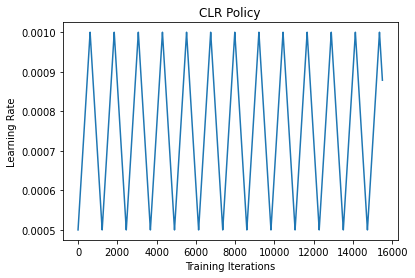

In [ ]:
# Summarize CLR policy
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR Policy")
plt.plot(h['iterations'], h['lr'])
plt.show()

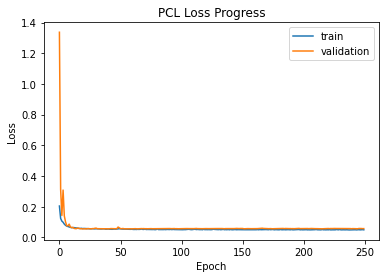

In [ ]:
# Summarize history for PCL Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('PCL Loss Progress')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

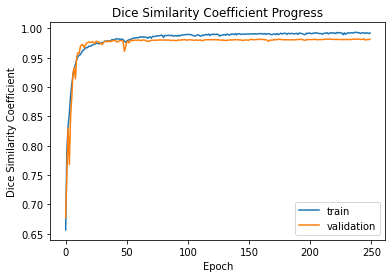

In [ ]:
# Summarize history for dice_coef
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Dice Similarity Coefficient Progress')
plt.ylabel('Dice Similarity Coefficient')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

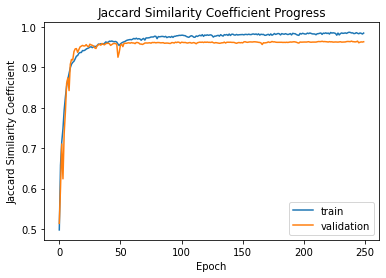

In [ ]:
# Summarize history for jacard_coef
plt.plot(history.history['jacard_coef'])
plt.plot(history.history['val_jacard_coef'])
plt.title('Jaccard Similarity Coefficient Progress')
plt.ylabel('Jaccard Similarity Coefficient')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()